# Inference of parameters with latent variables (SIR model)
In this notebook, we consider the SIR model with symptomatically and asymptomatically infected. We are trying to infer the parameters of the model 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 

when given the full data (of classes S, Ia, Is) from a generated trajectory.

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 
from scipy.linalg import eig

## 1) Generate a trajectory
We generate a test trajectory on a population with two ages groups.

In [2]:
M  = 2          # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            # recovery rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 1          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([20, 20])  # each age group has asymptomatic infectives
Is0 = np.array([20, 20])   # and also symptomatic infectives
R0  = np.array([0, 0])  # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('latent_SIR_traj.npy', data_array)

In [3]:
contactMatrix(0)

array([[18.,  9.],
       [ 3., 12.]])

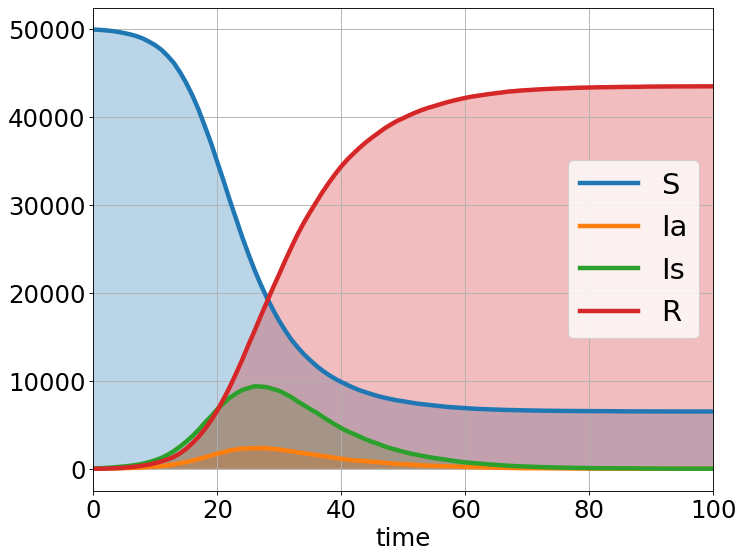

In [4]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
t = data['t']

plt.fill_between(t, 0, np.sum(data_array[:, :M], axis=1),  alpha=0.3)
plt.plot(t, np.sum(data_array[:, :M], axis=1), '-', label='S', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, M:2*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-', label='Ia', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, 2*M:3*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-', label='Is', lw=4)

plt.fill_between(t, 0, N - np.sum(data_array[:, :], axis=1), alpha=0.3)
plt.plot(t, N - np.sum(data_array[:, :], axis=1), '-', label='R', lw=4)

plt.legend(fontsize=26)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

## 2) Inference
We take the first $20$ data points of the $I_\mathrm{s}$ trajectory and use it to infer the parameters of the model.

In [5]:
# load the data and rescale to intensive variables 
N_start = 5 
Tf_inference = 15
Nf_inference = Tf_inference + 1

x = np.load('latent_SIR_traj.npy').astype('float')
x = x[N_start:N_start+Nf_inference]

# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, Ni)

### 2.1) Make a filter for the observed data 
We want a matrix $\boldsymbol{F}$ such that 
$$
\boldsymbol{F}\boldsymbol{x} = \boldsymbol{x}_\mathrm{obs}
$$

In [6]:
# a filter that gives the symptomatic infected
fltr = np.kron([0, 0, 1],np.identity(M))
print(fltr)

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


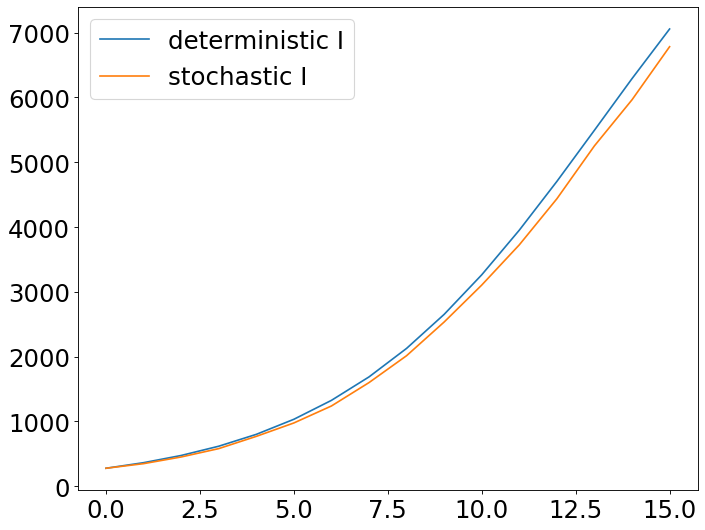

In [7]:
# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
obs=np.einsum('ij,kj->ki', fltr, x)

x0=x[0]

estimator.set_det_model(parameters)
estimator.set_contact_matrix(contactMatrix)
xm = estimator.integrate(x[0], 0, Tf_inference, Nf_inference)
det_obs = np.einsum('ij,kj->ki', fltr, xm)
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(np.sum(det_obs, axis=1), label='deterministic I')
plt.plot(np.sum(obs, axis=1), label='stochastic I')
plt.legend()
plt.show()

In [8]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

logp = estimator.minus_logp_red(parameters, x0, obs, fltr, Tf_inference, contactMatrix, tangent=False)

end_time = time.time()
print(logp) 
print(end_time - start_time)

127.86634868415052
0.22785615921020508


In [11]:
# make parameter guesses and set up bounds for each parameter 
eps=1e-4
param_priors = {
    'alpha':{
        'mean': 0.2, 
        'std': 0.05, 
        'bounds': [eps, 0.5]
    },
    'beta':{
        'mean': 0.04, 
        'std': 0.1,
        'bounds': [eps, 0.4]
    }, 
    'gIa':{
        'mean': 0.13, 
        'std': 0.05, 
        'bounds': [eps, 0.3]
    }, 
    'gIs':{
        'mean': 0.14, 
        'std': 0.05, 
        'bounds': [eps, 0.3]
    }
}

Ia0_g = x0[M:2*M]
Ia_std = Ia0_g*5
bounds_for_Ia = np.tile([0.1, 1000], M).reshape(M, 2)

S0_g = x0[:M]# need the sum of S0_g + I0 (observed in this case) over each age group to be smaller than fi 
S_std = Ia_std
bounds_for_S = np.array([(0.1, n-1) for n in Ni]).reshape(M, 2)

init_fltr = np.repeat([True, True, False], M)

init_priors = {
    'independent':{
        'fltr': init_fltr, 
        'mean': [*S0_g, *Ia0_g], 
        'std': [*S_std, *Ia_std], 
        'bounds': [*bounds_for_S, *bounds_for_Ia]
    }
}

# optimisation parameters 
ftol = 1e-6 # the relative tol in (-logp)  

estimator.set_det_method('RK2')
estimator.set_lyapunov_method('euler') # use faster methods 
start_time = time.time()
res = estimator.latent_infer_parameters(obs, fltr, Tf_inference, contactMatrix, param_priors, init_priors, 
                                            tangent=True, global_max_iter=50, global_atol=1, 
                                           cma_processes=1, verbose=True, ftol=ftol)
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 8 (seed=1516908715, Wed Jun 24 20:59:05 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 1.082458364488041e+04 1.0e+00 9.86e-01  5e-02  2e+02 0:00.2
    2     32 1.741001897833921e+03 1.3e+00 1.00e+00  5e-02  2e+02 0:00.4
    3     48 1.692793704108803e+02 1.4e+00 1.12e+00  5e-02  3e+02 0:00.5
   25    400 4.245426710582606e+02 3.9e+00 1.11e+00  4e-02  2e+02 0:03.6
Optimal value (global minimisation):  169.2793704108803
Starting local minimisation...
Optimal value (local minimisation):  138.82001643063865
8.790122032165527


In [16]:
# print the correct params and best estimates 
print('True parameters')
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
print(parameters)

best_estimates = res['map_params_dict']
print('\n Best estimates')
print(res['map_params_dict'])

print('\n True initial conditions: ') 
print((x[0]).astype('int'))


map_x0 = res['map_x0']
print('\n Inferred initial conditons: ') 
print(map_x0)

logp = estimator.minus_logp_red(best_estimates, map_x0, obs, fltr, Tf_inference, contactMatrix, tangent=True)

print('\n log p for best estimates:')
print(logp)

True parameters
{'alpha': 0.2, 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 1}

 Best estimates
{'alpha': 0.17519447733699595, 'beta': 0.020247994758180385, 'gIa': 0.08099275213458004, 'gIs': 0.15620660204144882, 'fsa': array([1., 1.])}

 True initial conditions: 
[12264 37254    34    39   132   145]

 Inferred initial conditons: 
[1.20949287e+04 3.68752840e+04 2.89845145e+01 3.31880139e-01
 1.32000000e+02 1.45000000e+02]

 log p for best estimates:
125.70162397010944


### 2.2) Plot forecast

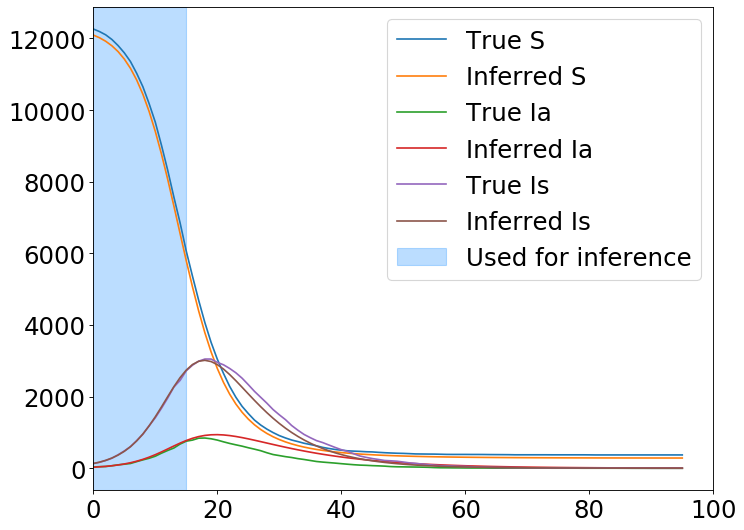

In [17]:
# plot the guessed trajectory and the true trajectory 
estimator.set_params(best_estimates)
estimator.set_det_model(best_estimates)
x_det = estimator.integrate(map_x0, N_start-1, Tf, Nf-N_start, method='LSODA')
x = np.load('latent_SIR_traj.npy').astype('float')[N_start:]
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(x[:,0], label='True S')
plt.plot(x_det[:, 0], label='Inferred S')
plt.plot(x[:,1*M], label='True Ia')
plt.plot(x_det[:, 1*M], label='Inferred Ia')
plt.plot(x[:,2*M], label='True Is')
plt.plot(x_det[:, 2*M], label='Inferred Is')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.legend()
plt.show()

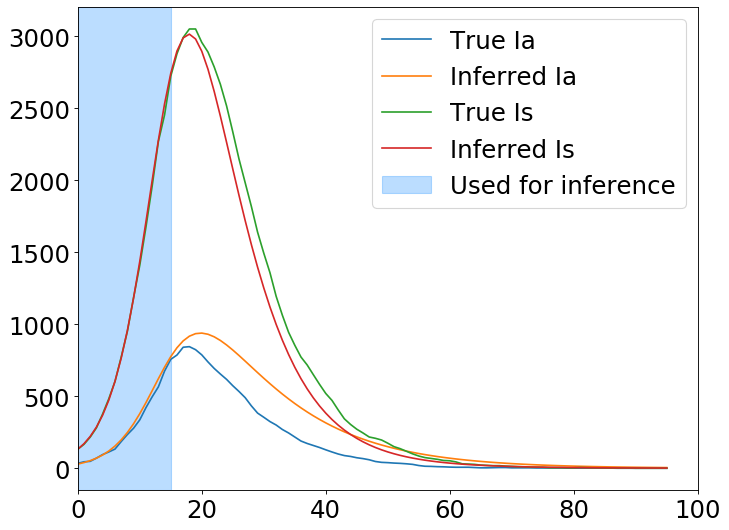

In [18]:
# replot the infected 
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(x[:,1*M], label='True Ia')
plt.plot(x_det[:, 1*M], label='Inferred Ia')
plt.plot(x[:,2*M], label='True Is')
plt.plot(x_det[:, 2*M], label='Inferred Is')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.legend()
plt.show()

### 2.3) Compute the Fisher Information matrix (FIM) for inferred epidemiological parameters and initial conditions

In [17]:
obs0=obs[0]

In [18]:
start_time = time.time()
FIM = estimator.FIM(keys, init_fltr, params, obs0, fltr,
                   Tf_inference, Nf_inference, contactMatrix, dx=None, 
                   tangent=True,
                   infer_scale_parameter = False)
end_time = time.time()
print(end_time - start_time)

1.294734239578247


In [19]:
# check if FIM is positive definite
np.all(np.linalg.eigvals(FIM) > 0)

True

In [20]:
# compute 'expected' Bayesian credible intervals for inferred parameters
# for flat priors these give a lower bound for a posteriori credible intervals
expected_BCI = np.sqrt(np.diagonal(np.linalg.inv(FIM)))
expected_BCI

array([0.15698645, 0.00431599, 0.31244129, 0.03752918, 0.06129005,
       0.19098953, 0.00066711, 0.00080767])

In [21]:
# compute normalized sensitivity measure from 
# 'Sensitivity, robustness, and identifiability in 
# stochastic chemical kinetics models' by Komorowski et al, equation (20)
# https://www.pnas.org/content/108/21/8645
evals, evecs = eig(FIM)

L = np.diag(np.real(evals))
C_ = evecs 

S_ij = np.sqrt(L)@C_
S2_ij = S_ij**2
S2_j = np.sum(S2_ij, axis=0)
Norm = np.sum(S2_j)
T_j = np.divide(S2_j,Norm)

## Sensitivity measure
T_j

array([0.05597258, 0.05480221, 0.00152197, 0.00600572, 0.35992407,
       0.27810083, 0.13888666, 0.10478596])

In [22]:
start_time = time.time()
FIM_det = estimator.FIM_det(keys, init_fltr, params, obs0, fltr,
                   Tf_inference, Nf_inference, contactMatrix, dx=None, 
                   infer_scale_parameter = False,
                       measurement_error=1e-2)
end_time = time.time()
print(end_time - start_time)

0.3515501022338867


In [23]:
# compute normalized sensitivity measure from 
# 'Sensitivity, robustness, and identifiability in 
# stochastic chemical kinetics models' by Komorowski et al, equation (20)
# https://www.pnas.org/content/108/21/8645
evals, evecs = eig(FIM_det)

L = np.diag(np.real(evals))
C_ = evecs 

S_ij = np.sqrt(L)@C_
S2_ij = S_ij**2
S2_j = np.sum(S2_ij, axis=0)
Norm = np.sum(S2_j)
T_j = np.divide(S2_j,Norm)

## Sensitivity measure
T_j

array([4.64399986e-03, 6.49914187e-03, 3.76876526e-05, 2.75282380e-03,
       4.52284611e-02, 2.02448496e-01, 7.36427111e-01, 1.96227914e-03])

### Next step (working progress): sample the parameters with nested sampling to get a better prediction. 